# $\alpha_1(1)$ sensitivity analysis

In [1]:
push!(LOAD_PATH, pwd()) # put current directory on path
using Revise
using UnPack
#include("ModelHelperFuns.jl")  # load the file
#using .ModelHelperFuns         # bring the module into scope
using CooperativeHuntingPkg
using Plots
default(
    guidefontsize=14,   # controls xlabel, ylabel, title font size
    tickfontsize=12,    # controls axis number labels
    legendfontsize=14,  # controls legend font
    linewidth=2,        # controls default line thickness
    grid = false,        # turns off grid in background
    fontfamily="Computer Modern" # font family that matches latex
)
using LaTeXStrings
using BifurcationKit, DifferentialEquations
# pgfplotsx()  # Set PGFPlotsX as the backend # this seems to not work on my computer, or on vscode.
using Measures # helps for adjusting location of axis labels
using LinearAlgebra, ForwardDiff
bif_fig_path = "/Users/taliaborofsky/Documents/CH_GroupFormation/CH_manuscript/FIgures/BifurcationDiagrams/"

"/Users/taliaborofsky/Documents/CH_GroupFormation/CH_manuscript/FIgures/BifurcationDiagrams/"

## Only Population Dynamics

In [3]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1.0,
    :x => 5.0,
    :scale => 3.0
)

Dict{Symbol, Float64} with 12 entries:
  :α1_of_1 => 0.05
  :A1      => 0.6
  :x       => 5.0
  :H2b     => 0.0
  :A2      => 0.5
  :s1      => 2.0
  :H1a     => 0.0
  :H2a     => 0.0
  :scale   => 3.0
  :α2_of_1 => 0.95
  :η2      => 0.6
  :β2      => 1.0

## Check with Heatmap - Type I

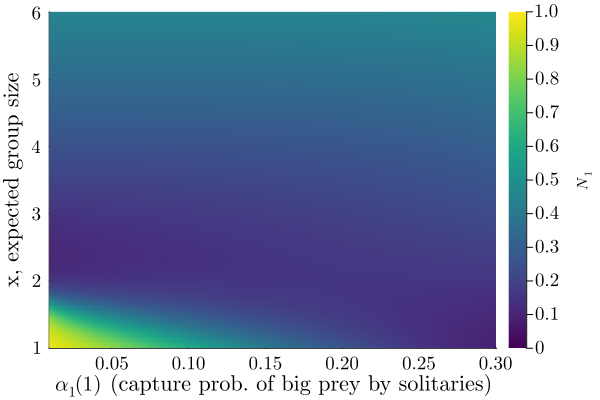

In [4]:
# vary alpha1 and x for scale = 4.0
params = deepcopy(params_base)
params[:scale] = 4.0



# Grids - alpha1 by x
nα1   = 200
nx   = 200
α1vec   = range(0.01, stop=0.3, length=nα1)
xvec = range(1.0, stop=6.0, length=nx)  # adjust range as needed

# Output matrix: rows = H2b, cols = δ
Pmat = fill(NaN, nx, nα1)
N1mat = fill(NaN, nx, nα1)
N2mat = fill(NaN, nx, nα1)
for (j, α1) in enumerate(α1vec)
    for (i, x) in enumerate(xvec)
        # build clean param set for this (δ, H2b)
        params[:x] = x
        params[:α1_of_1] = α1
        params = scale_parameters(params)
        # don't need ot rescale
        u_eq = equilibrium_nogroups(params)  # returns [N1, N2, P]
        J = ForwardDiff.jacobian(u -> system_nogroups(u, params, 1),u_eq)
        evals_real = real(eigen(J).values)
        
        if all(u_eq .> 0) && all(evals_real .< 0)
            Pmat[i, j] = u_eq[end]
            N1mat[i, j] = u_eq[1]
            N2mat[i,j] = u_eq[2]
        end
    end
end
maxP = maximum(Pmat[.!isnan.(Pmat)], dims = 1)[1]
hm_P = heatmap(
    α1vec, xvec, Pmat;
    xlabel = L"$\alpha_1(1)$ (capture prob. of big prey by solitaries)",
    ylabel = "x, expected group size",
    colorbar_title = "\n"*"P",
    c = :viridis,
    nan_color = :white,
    lw = 0,
    clims = (0, maxP),
    right_margin = 5mm 
)
hm_N = heatmap(
    α1vec, xvec, N1mat;
    xlabel = L"$\alpha_1(1)$ (capture prob. of big prey by solitaries)",
    ylabel = "x, expected group size",
    colorbar_title = "\n"*L"N_1",
    c = :viridis,
    nan_color = :white,
    lw = 0,
    clims = (0, 1.0),
    right_margin = 5mm
)

savefig(hm_N, bif_fig_path*"alpha1_sensitivity_N1_t1_hm.pdf")
hm_N
# note: isnan.(Pmat) returns a matrix, so the . must turn it into a vector


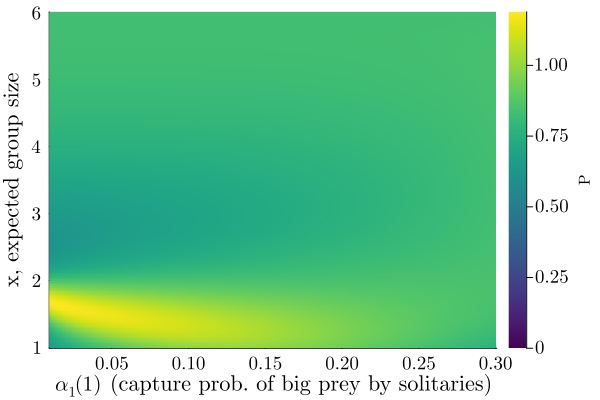

In [6]:
savefig(hm_P, bif_fig_path*"alpha1_sensitivity_P_t1_hm.pdf")

hm_P


In [100]:
hm_N2 = heatmap(
    α1vec, xvec, N2mat;
    xlabel = L"$\alpha_1(1)$ (capture prob. of big prey by solitaries)",
    ylabel = "x, expected group size",
    colorbar_title = "\n"*L"N_1",
    c = :viridis,
    nan_color = :white,
    lw = 0,
    clims = (0, 1.0),
    right_margin = 5mm
)
savefig(hm_N2, bif_fig_path*"alpha1_sensitivity_N2_t1_hm.pdf")


"/Users/taliaborofsky/Documents/CH_GroupFormation/CH_manuscript/FIgures/BifurcationDiagrams/alpha1_sensitivity_N2_t1_hm.pdf"

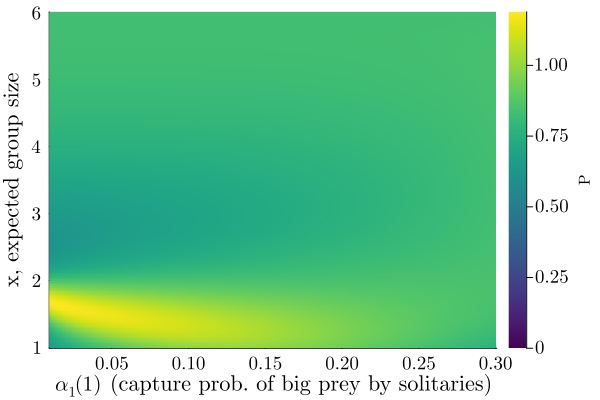

hi

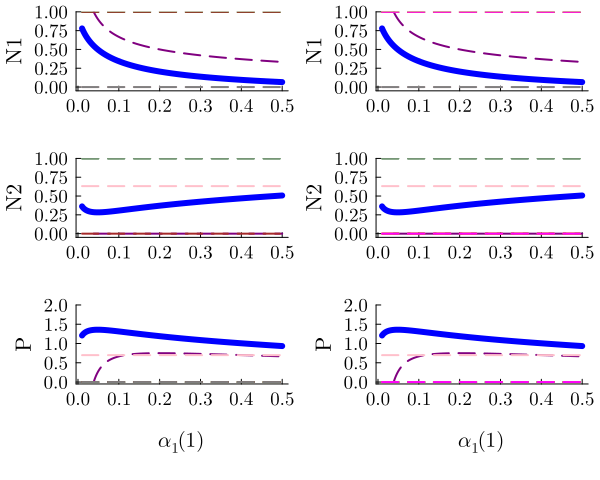

In [101]:
params = deepcopy(params_base)
params[:x] = 1.5
params[:α1_of_1] = 0.05
p_nt = NamedTuple(scale_parameters(params))

# br_list = do_base_continuations_nog(
#             p_nt; lens = (@optic _.x), 
#             p_min = 1.01, p_max = 9.0, 
#             systemfunction =system_scaled_nogroups, 
#             dsmax = 0.01)


br_list, extra_branches = diagram_2_recursion_nog(
    p_nt; paramkey = :α1_of_1, p_min = 0.01, p_max = 0.5, lens = (@optic _.α1_of_1));
plot_comparison_branches_filtered(
        br_list, [br_list..., extra_branches...], :α1_of_1; 
        ymax = 2.0, has_g = false, x_max = 5)

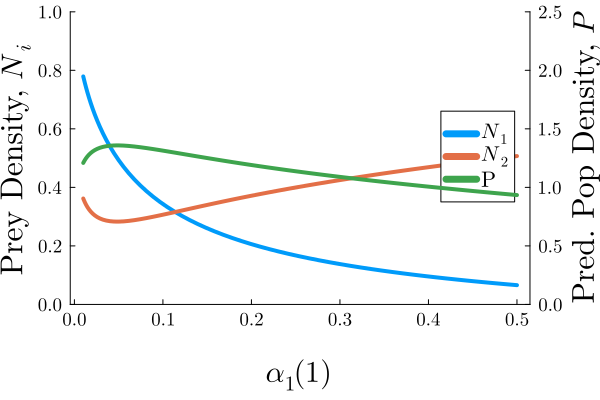

In [29]:
br_coexist = br_list[:coexist]
filtered_coexist = extract_branch_matrix_nog(br_coexist, 5)
indices = findall(xvec -> xvec==1.0, filtered_coexist.stable)
indices = findall(xvec -> xvec==1.0, filtered_coexist.stable)
stable_coexist = Dict()
for (key, value) in pairs(filtered_coexist)
    stable_coexist[key] = value[indices]
end
plt_N = plot(
    stable_coexist[:param], 
    stable_coexist[:N1], 
    label = L"N_1",
    linewidth=4
    )
plot!(
    stable_coexist[:param], 
    stable_coexist[:N2], 
    label = L"N_2",
    linewidth=4,
    ylims = [0,1.0]
    )
plot!([],[],color=3, linewidth=4, label = "P")
plot!(ylab = L"Prey Density, $N_i$",
    xlab = "\n"*L"\alpha_1(1)",
    bottommargin = 5mm,
    guidefontsize=20,
    legend = :right
    )#ylab = "Scaled Prey Density\nat Equilibrium"

plot!(
    twinx(), stable_coexist[:param], stable_coexist[:P], 
    label = nothing,#[L"N_2 \to N_1"], 
    ylabel = L"Pred. Pop Density, $P$",
    color = 3,
        guidefontsize=20,
    linewidth=4,
    ylims = [0,2.5])

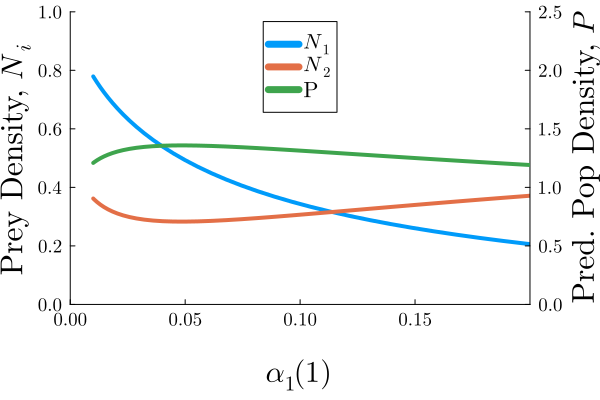

In [33]:
plt_N
plot!(xlims = [0,0.2], legend = :top)

If predators are solitary, $N_1$ is sensitive to $\alpha_1(1)$, but other variables are not.

## Check with Heatmap - Type II

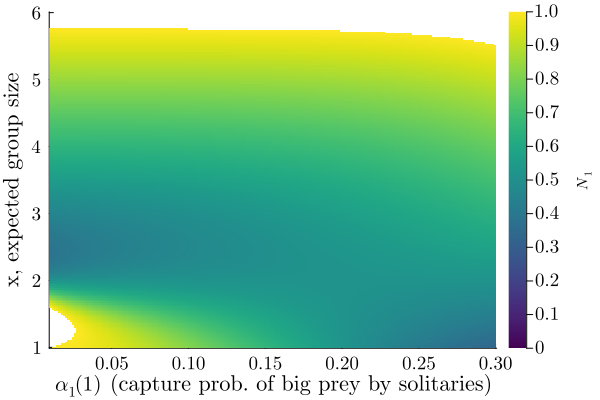

In [107]:
# vary alpha1 and x for scale = 4.0
params = deepcopy(params_base)
params[:scale] = 4.0
params[:H2b] = 1.0


# Grids - alpha1 by x
nα1   = 200
nx   = 200
α1vec   = range(0.01, stop=0.3, length=nα1)
xvec = range(1.0, stop=6.0, length=nx)  # adjust range as needed

# Output matrix: rows = H2b, cols = δ
Pmat = fill(NaN, nx, nα1)
N1mat = fill(NaN, nx, nα1)
N2mat = fill(NaN, nx, nα1)
for (j, α1) in enumerate(α1vec)
    for (i, x) in enumerate(xvec)
        # build clean param set for this (δ, H2b)
        params[:x] = x
        params[:α1_of_1] = α1
        params = scale_parameters(params)
        # don't need ot rescale
        u_eq = equilibrium_nogroups(params)  # returns [N1, N2, P]
        J = ForwardDiff.jacobian(u -> system_nogroups(u, params, 1),u_eq)
        evals_real = real(eigen(J).values)
        
        if all(u_eq .> 0) && all(evals_real .< 0)
            Pmat[i, j] = u_eq[end]
            N1mat[i, j] = u_eq[1]
            N2mat[i, j] = u_eq[2]
        end
    end
end
maxP = maximum(Pmat[.!isnan.(Pmat)], dims = 1)[1]
hm_P = heatmap(
    α1vec, xvec, Pmat;
    xlabel = L"$\alpha_1(1)$ (capture prob. of big prey by solitaries)",
    ylabel = "x, expected group size",
    colorbar_title = "\n"*"P",
    c = :viridis,
    nan_color = :white,
    lw = 0,
    clims = (0, maxP),
    right_margin = 5mm 
)
hm_N = heatmap(
    α1vec, xvec, N1mat;
    xlabel = L"$\alpha_1(1)$ (capture prob. of big prey by solitaries)",
    ylabel = "x, expected group size",
    colorbar_title = "\n"*L"N_1",
    c = :viridis,
    nan_color = :white,
    lw = 0,
    clims = (0, 1.0),
    right_margin = 5mm
)

savefig(hm_N, bif_fig_path*"alpha1_sensitivity_N_t2_hm.pdf")
# note: isnan.(Pmat) returns a matrix, so the . must turn it into a vector
hm_N

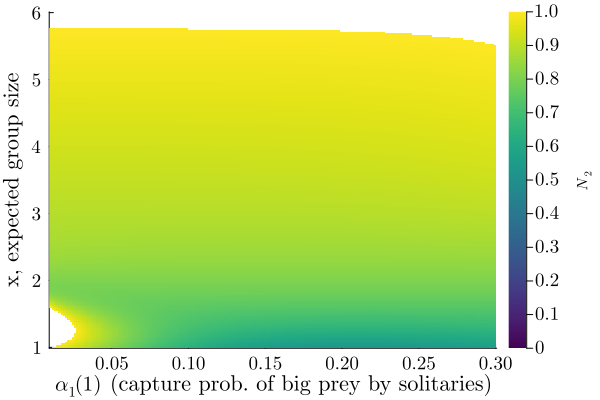

In [108]:
hm_N2 = heatmap(
    α1vec, xvec, N2mat;
    xlabel = L"$\alpha_1(1)$ (capture prob. of big prey by solitaries)",
    ylabel = "x, expected group size",
    colorbar_title = "\n"*L"N_2",
    c = :viridis,
    nan_color = :white,
    lw = 0,
    clims = (0, 1.0),
    right_margin = 5mm
)

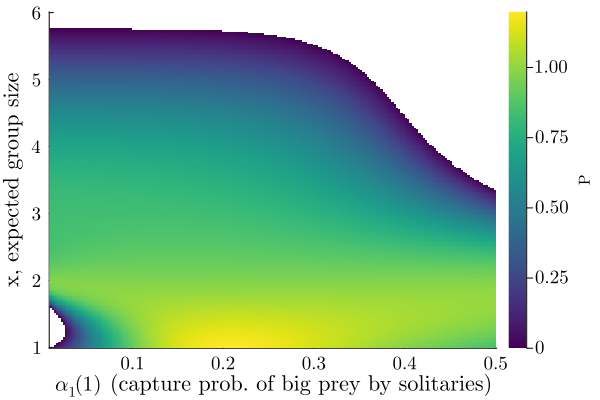

In [103]:
savefig(hm_P, bif_fig_path*"alpha1_sensitivity_P_t2_hm.pdf")

hm_P

hi

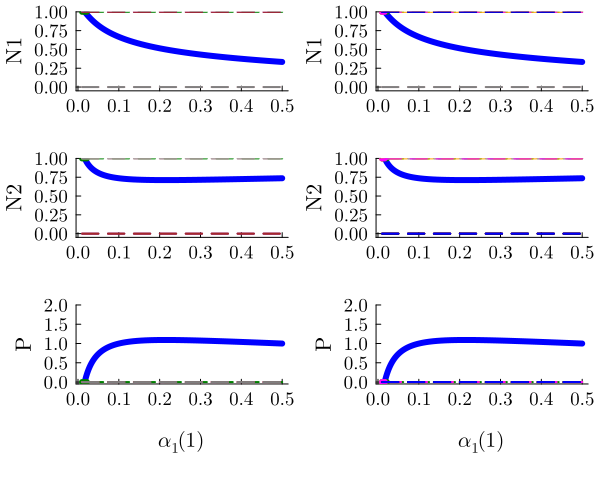

In [52]:
params = deepcopy(params_base)
params[:scale] = 4.0
params[:α1_of_1] = 0.05
params[:H2b] = 1.0
params[:x] = 1.5
p_nt = NamedTuple(scale_parameters(params))

# br_list = do_base_continuations_nog(
#             p_nt; lens = (@optic _.x), 
#             p_min = 1.01, p_max = 9.0, 
#             systemfunction =system_scaled_nogroups, 
#             dsmax = 0.01)


br_list, extra_branches = diagram_2_recursion_nog(
    p_nt; paramkey = :α1_of_1, p_min = 0.01, p_max = 0.5, lens = (@optic _.α1_of_1));
plot_comparison_branches_filtered(
        br_list, [br_list..., extra_branches...], :α1_of_1; 
        ymax = 2.0, has_g = false, x_max = 5)

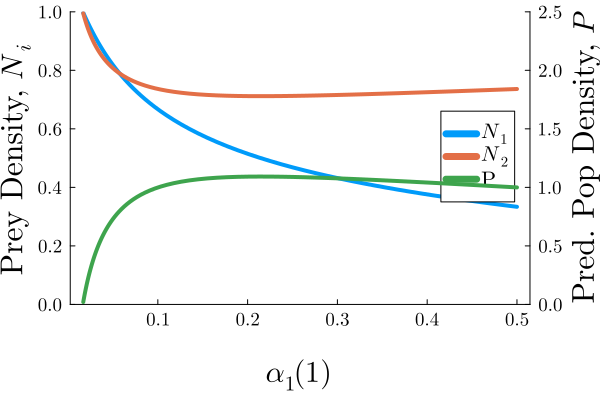

In [53]:
br_coexist = br_list[:coexist]
filtered_coexist = extract_branch_matrix_nog(br_coexist, 5)
indices = findall(xvec -> xvec==1.0, filtered_coexist.stable)
indices = findall(xvec -> xvec==1.0, filtered_coexist.stable)
stable_coexist = Dict()
for (key, value) in pairs(filtered_coexist)
    stable_coexist[key] = value[indices]
end
plt_N = plot(
    stable_coexist[:param], 
    stable_coexist[:N1], 
    label = L"N_1",
    linewidth=4
    )
plot!(
    stable_coexist[:param], 
    stable_coexist[:N2], 
    label = L"N_2",
    linewidth=4,
    ylims = [0,1.0]
    )
plot!([],[],color=3, linewidth=4, label = "P")
plot!(ylab = L"Prey Density, $N_i$",
    xlab = "\n"*L"\alpha_1(1)",
    bottommargin = 5mm,
    guidefontsize=20,
    legend = :right
    )#ylab = "Scaled Prey Density\nat Equilibrium"

plot!(
    twinx(), stable_coexist[:param], stable_coexist[:P], 
    label = nothing,#[L"N_2 \to N_1"], 
    ylabel = L"Pred. Pop Density, $P$",
    color = 3,
        guidefontsize=20,
    linewidth=4,
    ylims = [0,2.5])

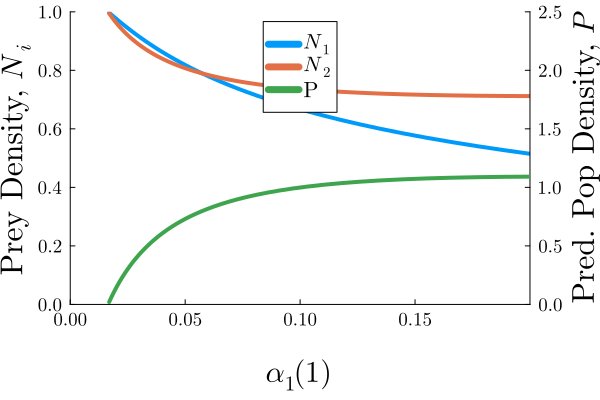

In [54]:
plt_N
plot!(xlims = [0,0.2], legend = :top)

# Full Dynamics

## Type I

Dict{Symbol, Any}(:A1 => 0.6, :H2b => 0.0, :scale => 5.0, :s1 => 2.0, :H1a => 0.0, :H2a => 0.0, :x_max => 10, :α2_of_1 => 0.95, :η2 => 0.6, :α2_fun_type => "constant", :s2 => 2.0, :α1_of_1 => 0.05, :Tg => 0.01, :d => 100.0, :A2 => 0.5, :β2 => 1.0)


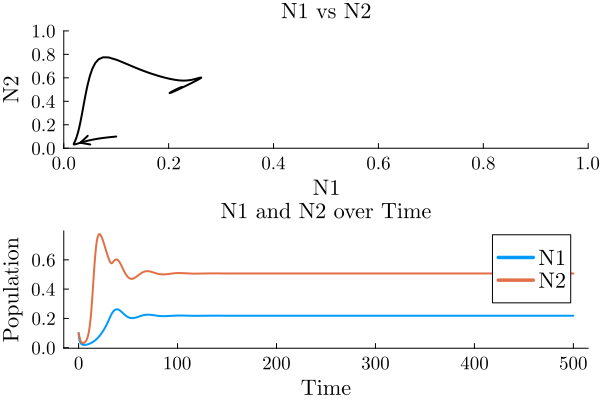

In [3]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 0.0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1.0,
    :α2_fun_type => "constant",
    :x_max => 10,
    :Tg => .01,
    :d => 100.0,
    :scale => 5.0
)
u0 = [0.1,0.1, fill(0.1,params_base[:x_max])...]

params = deepcopy(params_base)
params[:H1a] = params[:H2a] = 0.0
#params[:H2b] = 1.0
println(params)
x_max = params[:x_max]
u0 = fill(0.1, x_max+2)
p_nt = NamedTuple(scale_parameters(params))
sol, plotN1N2 = simulate_and_plot(u0, p_nt; tf = 500)
plotN1N2


hi

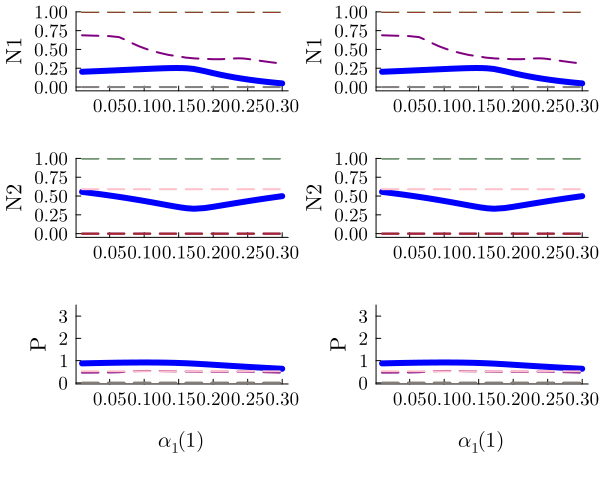

In [4]:
br_list, extra_branches = diagram_2_recursion(
    p_nt, paramkey = :α1_of_1; p_min = 0.01, p_max = 0.3, 
    lens = (@optic _.α1_of_1), systemfunction = fullsystem_scaled);
#plot_comparison_branches(br_list, extra_branches; ymax = 3.5)
plot_comparison_branches_filtered(br_list, [br_list...,extra_branches...], 
        :α1_of_1; ymax = 3.5)

In [5]:
br_coexist = br_list[:coexist]
filtered_coexist = extract_branch_matrix(br_coexist, params[:x_max])
indices = findall(xvec -> xvec==1.0, filtered_coexist.stable)
stable_coexist = Dict()
for (key, value) in pairs(filtered_coexist)
    stable_coexist[key] = value[indices]
end

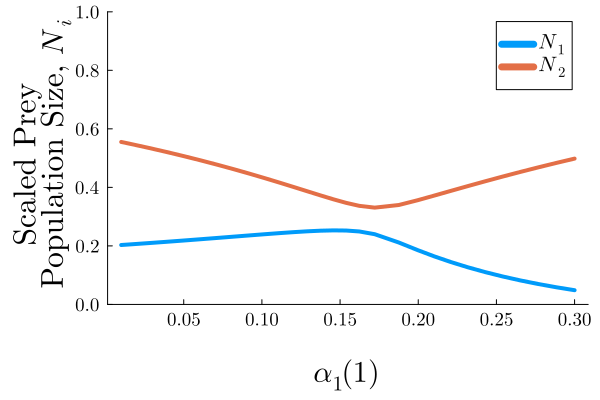

In [6]:
plt_N = plot(
    stable_coexist[:param], 
    stable_coexist[:N1], 
    label = L"N_1",
    linewidth=4
)
plot!(
    stable_coexist[:param], 
    stable_coexist[:N2], 
    label = L"N_2",
    linewidth=4
)
plot!(
    ylab = "Scaled Prey \n Population Size, "*L"$N_i$",
    xlab = "\n"*param_label_dic[:α1_of_1],
    bottommargin = 5mm,
    left_margin=5mm,
    ylims = [0,1],
    guidefontsize=20)

savefig(plt_N, bif_fig_path*"alpha1_sensitivity_full_t1_prey")
plt_N

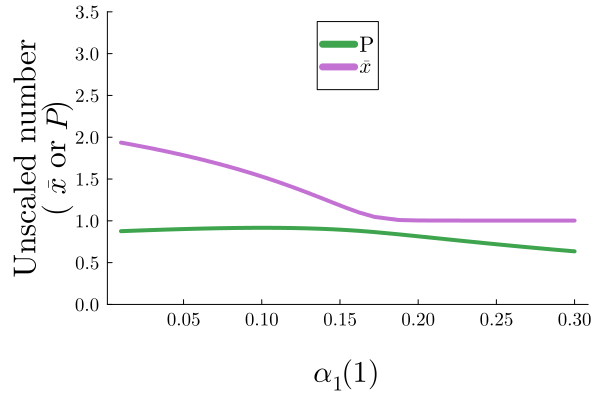

In [7]:
plt_pred = plot( 
    stable_coexist[:param], stable_coexist[:P], 
    label = "P", 
    color = 3,
    linewidth=4,
    ylims = [0,3.5]
)
plot!(
    ylab = "Unscaled number\n"* L"( $\bar{x}$ or $P$)",
    xlab = "\n"*param_label_dic[:α1_of_1],
    bottommargin = 5mm,
    left_margin = 5mm,
    guidefontsize=20,
    legend = :top
)
plot!(
    stable_coexist[:param], stable_coexist[:mean_x],
    label = L"$\bar{x}$",
    color = 4,
    linewidth = 4
)
savefig(plt_pred, bif_fig_path*"alpha1_sensitivity_full_t1_pred")
plt_pred

## Type II

Dict{Symbol, Any}(:A1 => 0.6, :H2b => 1.0, :scale => 5.0, :s1 => 2.0, :H1a => 0.0, :H2a => 0.0, :x_max => 10, :α2_of_1 => 0.95, :η2 => 0.6, :α2_fun_type => "constant", :s2 => 2.0, :α1_of_1 => 0.05, :Tg => 0.01, :d => 100.0, :A2 => 0.5, :β2 => 1.0)


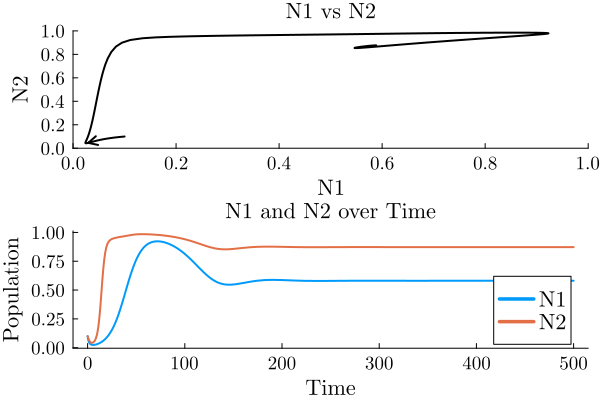

In [9]:
params_base = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2.0,
    :s2 => 2.0,
    :H1a => 0.0,
    :H2a => 0.0,
    :H2b => 1.0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1.0,
    :α2_fun_type => "constant",
    :x_max => 10,
    :Tg => .01,
    :d => 100.0,
    :scale => 5.0
)
u0 = [0.1,0.1, fill(0.1,params_base[:x_max])...]

params = deepcopy(params_base)
params[:H1a] = params[:H2a] = 0.0
params[:H2b] = 1.0
println(params)
x_max = params[:x_max]
u0 = fill(0.1, x_max+2)
p_nt = NamedTuple(scale_parameters(params))
sol, plotN1N2 = simulate_and_plot(u0, p_nt; tf = 500)
plotN1N2


hi

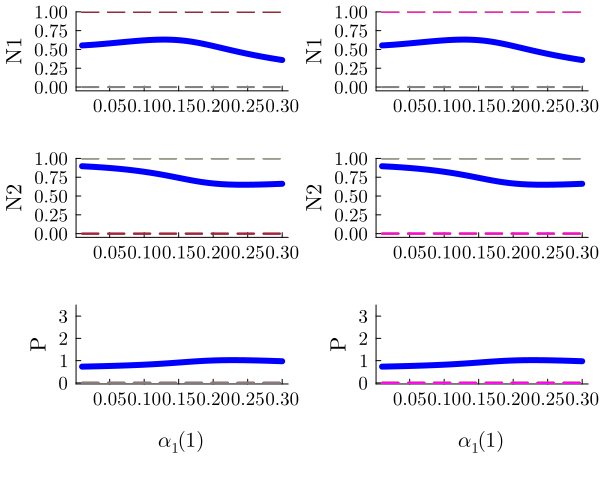

In [10]:
br_list, extra_branches = diagram_2_recursion(
    p_nt, paramkey = :α1_of_1; p_min = 0.01, p_max = 0.3, 
    lens = (@optic _.α1_of_1), systemfunction = fullsystem_scaled);
#plot_comparison_branches(br_list, extra_branches; ymax = 3.5)
plot_comparison_branches_filtered(br_list, [br_list...,extra_branches...], 
        :α1_of_1; ymax = 3.5)

In [11]:
br_coexist = br_list[:coexist]
filtered_coexist = extract_branch_matrix(br_coexist, params[:x_max])
indices = findall(xvec -> xvec==1.0, filtered_coexist.stable)
stable_coexist = Dict()
for (key, value) in pairs(filtered_coexist)
    stable_coexist[key] = value[indices]
end

In [12]:
plt_N = plot(
    stable_coexist[:param], 
    stable_coexist[:N1], 
    label = L"N_1",
    linewidth=4
)
plot!(
    stable_coexist[:param], 
    stable_coexist[:N2], 
    label = L"N_2",
    linewidth=4
)
plot!(
    ylab = "Scaled Prey \n Population Size, "*L"$N_i$",
    xlab = "\n"*param_label_dic[:α1_of_1],
    bottommargin = 5mm,
    left_margin=5mm,
    ylims = [0,1],
    guidefontsize=20)

savefig(plt_N, bif_fig_path*"alpha1_sensitivity_full_t2_prey")

"/Users/taliaborofsky/Documents/CH_GroupFormation/CH_manuscript/FIgures/BifurcationDiagrams/alpha1_sensitivity_full_t2_prey.png"

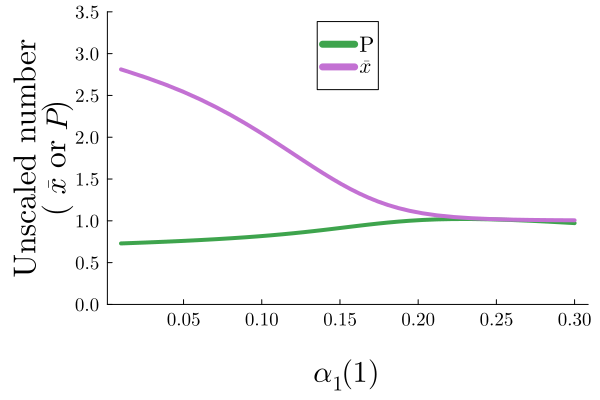

In [13]:
plt_pred = plot( 
    stable_coexist[:param], stable_coexist[:P], 
    label = "P", 
    color = 3,
    linewidth=4,
    ylims = [0,3.5]
)
plot!(
    ylab = "Unscaled number\n"* L"( $\bar{x}$ or $P$)",
    xlab = "\n"*param_label_dic[:α1_of_1],
    bottommargin = 5mm,
    left_margin = 5mm,
    guidefontsize=20,
    legend = :top
)
plot!(
    stable_coexist[:param], stable_coexist[:mean_x],
    label = L"$\bar{x}$",
    color = 4,
    linewidth = 4
)
savefig(plt_pred, bif_fig_path*"alpha1_sensitivity_full_t2_pred")
plt_pred